In [31]:
#本文档进行预测处理
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from huawei.split_data import get_data,series_to_supervised, get_predict_result
from huawei.state_predict import mean_value, mv_and_ar,arma, get_scores
import datetime
import warnings
warnings.filterwarnings("ignore") 

##设置绘图的大小
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

In [32]:
##读入数据
# 导入数据
#选用的服务器类型
columns = ["id","ecs","date","time"]
#读取数据
data = pd.read_table('data_set/data_2015_12_to_2016_01.txt',header=None,delim_whitespace=True,names=columns)
#转化成日期格式
data['date'] = pd.to_datetime(data['date'])
####设置需要的日期
train_begin_date = datetime.datetime(2015, 12, 1)
train_end_date = datetime.datetime(2016, 1, 22)
test_begin_date = datetime.datetime(2016, 1, 23)
test_end_date = datetime.datetime(2016, 1, 30)
train_data, test_data, test_target = get_data(data,train_begin_date,train_end_date,test_begin_date,test_end_date)
predict_len = int(str(test_end_date - test_begin_date)[0:2])

#print(train_data)
#print(test_data)

In [33]:
###对trian data进行预处理
mv_flag = True
if mv_flag:
    tmp_train_data = train_data.rolling(window=6).mean()
    train_data = tmp_train_data.dropna(axis=0, how='any')

In [34]:
###对train_data进行处理
ecs1_data = train_data["flavor1"]
split_windows = 7
ecs1_data = pd.DataFrame(ecs1_data)
#ecs1_data.rename(index=str, columns={"flavor1": "var(t)"})
cols, names = list(), list()
for i in range(split_windows+1):
    cols.append(ecs1_data.shift(i))
    names += [('var(t-%d)' % (i))]
agg = pd.concat(cols, axis=1)
agg.columns = names
agg.dropna(inplace=True)
agg = agg.rename(index=str, columns={"var(t-0)": "target"})
target = agg["target"]
agg.drop('target',axis=1, inplace=True)
index = [i for i in range(len(target)-split_windows, len(target))]
need_data = target[index].values
print (need_data)

[ 3.83333333  3.83333333  3.66666667  3.66666667  2.33333333  2.83333333
  4.        ]


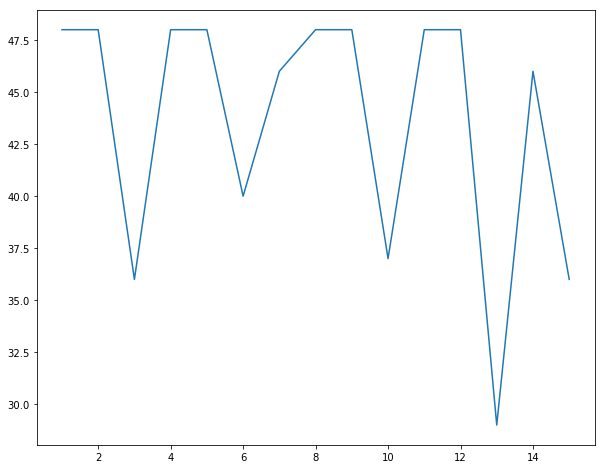

In [35]:
target_ecs = ["flavor1","flavor2","flavor3","flavor4","flavor5","flavor6","flavor7","flavor8","flavor9","flavor10","flavor11","flavor12","flavor13","flavor14","flavor15"]
count_num = []
count_dict = {}
for ecs in target_ecs:
    tmp_num = len(train_data[ecs][train_data[ecs]>0])
    count_num.append(tmp_num)
    count_dict[ecs] = tmp_num
ecs_index = range(1,16)
plt.plot(ecs_index, count_num)

In [36]:
from huawei.split_data import get_predict_result
from sklearn import linear_model
model_LinearRegression = linear_model.LinearRegression()
# ecs1_data = train_data["flavor9"]
split_windows = 7
# result = get_predict_result(ecs1_data, split_windows, model_LinearRegression)
# print (result)
predict_result = {}
for ecs in target_ecs:
    ecs_data = train_data[ecs]
    tmp_result = get_predict_result(ecs_data, split_windows, model_LinearRegression, mv_flag)
    predict_result[ecs] = tmp_result
print ("使用线性分类器：")
get_scores(predict_result,test_target,target_ecs) 
print ("删去低频")
#处理低频次的数据
from huawei.state_predict import mean_value
low_frep = []
date_sum =  int(str(train_end_date - train_begin_date)[0:2])
predict_len = int(str(test_end_date - test_begin_date)[0:2])
mean_predict_result = predict_result
base_rate = 0.3
for ecs, freq in count_dict.items():
    if (freq < date_sum*base_rate):
        low_frep.append(ecs)
for ecs in low_frep:
    ecs_data = train_data[ecs]
    mean_predict_result[ecs] = mean_value(train_data[ecs],date_sum,predict_len)
get_scores(mean_predict_result, test_target,target_ecs)

使用线性分类器：
predict scrore: 0.848963
删去低频
predict scrore: 0.848963


In [37]:
from huawei.split_data import get_predict_result
from sklearn import tree
tree_reg = tree.DecisionTreeRegressor()
# ecs1_data = train_data["flavor9"]
split_windows = 7
# result = get_predict_result(ecs1_data, split_windows, model_LinearRegression)
# print (result)
predict_result = {}
for ecs in target_ecs:
    ecs_data = train_data[ecs]
    tmp_result = get_predict_result(ecs_data, split_windows, tree_reg, mv_flag)
    predict_result[ecs] = tmp_result
print ("使用树回归器：")
get_scores(predict_result,test_target,target_ecs) 
print ("删去低频")
#处理低频次的数据
from huawei.state_predict import mean_value
low_frep = []
date_sum =  int(str(train_end_date - train_begin_date)[0:2])
predict_len = int(str(test_end_date - test_begin_date)[0:2])
mean_predict_result = predict_result
base_rate = 0.3
for ecs, freq in count_dict.items():
    if (freq < date_sum*base_rate):
        low_frep.append(ecs)
for ecs in low_frep:
    ecs_data = train_data[ecs]
    mean_predict_result[ecs] = mean_value(train_data[ecs],date_sum,predict_len)
get_scores(mean_predict_result, test_target,target_ecs)

使用树回归器：
predict scrore: 0.770630
删去低频
predict scrore: 0.770630


In [38]:
from huawei.split_data import get_predict_result
from sklearn import svm

svr = svm.SVR()
# ecs1_data = train_data["flavor9"]
split_windows = 7
# result = get_predict_result(ecs1_data, split_windows, model_LinearRegression)
# print (result)
predict_result = {}
for ecs in target_ecs:
    ecs_data = train_data[ecs]
    tmp_result = get_predict_result(ecs_data, split_windows, svr,mv_flag)
    predict_result[ecs] = tmp_result
print ("使用SVM回归器：")
get_scores(predict_result,test_target,target_ecs) 
print ("删去低频")
#处理低频次的数据
from huawei.state_predict import mean_value
low_frep = []
date_sum =  int(str(train_end_date - train_begin_date)[0:2])
predict_len = int(str(test_end_date - test_begin_date)[0:2])
mean_predict_result = predict_result
base_rate = 0.3
for ecs, freq in count_dict.items():
    if (freq < date_sum*base_rate):
        low_frep.append(ecs)
for ecs in low_frep:
    ecs_data = train_data[ecs]
    mean_predict_result[ecs] = mean_value(train_data[ecs],date_sum,predict_len)
get_scores(mean_predict_result, test_target,target_ecs)

使用SVM回归器：
predict scrore: 0.865610
删去低频
predict scrore: 0.865610


In [39]:
from huawei.split_data import get_predict_result
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor()
# ecs1_data = train_data["flavor9"]
split_windows = 7
# result = get_predict_result(ecs1_data, split_windows, model_LinearRegression)
# print (result)
predict_result = {}
for ecs in target_ecs:
    ecs_data = train_data[ecs]
    tmp_result = get_predict_result(ecs_data, split_windows, knn, mv_flag)
    predict_result[ecs] = tmp_result
print ("使用knn分类器：")
get_scores(predict_result,test_target,target_ecs) 
print ("删去低频")
#处理低频次的数据
from huawei.state_predict import mean_value
low_frep = []
date_sum =  int(str(train_end_date - train_begin_date)[0:2])
predict_len = int(str(test_end_date - test_begin_date)[0:2])
mean_predict_result = predict_result
base_rate = 0.3
for ecs, freq in count_dict.items():
    if (freq < date_sum*base_rate):
        low_frep.append(ecs)
for ecs in low_frep:
    ecs_data = train_data[ecs]
    mean_predict_result[ecs] = mean_value(train_data[ecs],date_sum,predict_len)
get_scores(mean_predict_result, test_target,target_ecs)

使用knn分类器：
predict scrore: 0.767979
删去低频
predict scrore: 0.767979


In [40]:
from huawei.split_data import get_predict_result
from sklearn import ensemble
rf =ensemble.RandomForestRegressor(n_estimators=50)
# ecs1_data = train_data["flavor9"]
split_windows = 7
# result = get_predict_result(ecs1_data, split_windows, model_LinearRegression)
# print (result)
predict_result = {}
for ecs in target_ecs:
    ecs_data = train_data[ecs]
    tmp_result = get_predict_result(ecs_data, split_windows, rf, mv_flag)
    predict_result[ecs] = tmp_result
print ("使用随机森林分类器：")
get_scores(predict_result,test_target,target_ecs) 
print ("删去低频")
#处理低频次的数据
from huawei.state_predict import mean_value
low_frep = []
date_sum =  int(str(train_end_date - train_begin_date)[0:2])
predict_len = int(str(test_end_date - test_begin_date)[0:2])
mean_predict_result = predict_result
base_rate = 0.3
for ecs, freq in count_dict.items():
    if (freq < date_sum*base_rate):
        low_frep.append(ecs)
for ecs in low_frep:
    ecs_data = train_data[ecs]
    mean_predict_result[ecs] = mean_value(train_data[ecs],date_sum,predict_len)
get_scores(mean_predict_result, test_target,target_ecs)

使用随机森林分类器：
predict scrore: 0.864760
删去低频
predict scrore: 0.864760


In [41]:
from huawei.split_data import get_predict_result
ada = ensemble.AdaBoostRegressor(n_estimators=50)
# ecs1_data = train_data["flavor9"]
split_windows = 7
# result = get_predict_result(ecs1_data, split_windows, model_LinearRegression)
# print (result)
predict_result = {}
for ecs in target_ecs:
    ecs_data = train_data[ecs]
    tmp_result = get_predict_result(ecs_data, split_windows, ada, mv_flag)
    predict_result[ecs] = tmp_result
print ("使用adboosting分类器：")
get_scores(predict_result,test_target,target_ecs) 
print ("删去低频")
#处理低频次的数据
from huawei.state_predict import mean_value
low_frep = []
date_sum =  int(str(train_end_date - train_begin_date)[0:2])
predict_len = int(str(test_end_date - test_begin_date)[0:2])
mean_predict_result = predict_result
base_rate = 0.3
for ecs, freq in count_dict.items():
    if (freq < date_sum*base_rate):
        low_frep.append(ecs)
for ecs in low_frep:
    ecs_data = train_data[ecs]
    mean_predict_result[ecs] = mean_value(train_data[ecs],date_sum,predict_len)
get_scores(mean_predict_result, test_target,target_ecs)


使用adboosting分类器：
predict scrore: 0.848283
删去低频
predict scrore: 0.848283


In [42]:
from huawei.split_data import get_predict_result
gbrt = ensemble.GradientBoostingRegressor(n_estimators=50)
# ecs1_data = train_data["flavor9"]
split_windows = 7
# result = get_predict_result(ecs1_data, split_windows, model_LinearRegression)
# print (result)
predict_result = {}
for ecs in target_ecs:
    ecs_data = train_data[ecs]
    tmp_result = get_predict_result(ecs_data, split_windows, gbrt, mv_flag)
    predict_result[ecs] = tmp_result
print ("使用GTRA分类器：")
get_scores(predict_result,test_target,target_ecs) 
print ("删去低频")
#处理低频次的数据
from huawei.state_predict import mean_value
low_frep = []
date_sum =  int(str(train_end_date - train_begin_date)[0:2])
predict_len = int(str(test_end_date - test_begin_date)[0:2])
mean_predict_result = predict_result
base_rate = 0.3
for ecs, freq in count_dict.items():
    if (freq < date_sum*base_rate):
        low_frep.append(ecs)
for ecs in low_frep:
    ecs_data = train_data[ecs]
    mean_predict_result[ecs] = mean_value(train_data[ecs],date_sum,predict_len)
get_scores(mean_predict_result, test_target,target_ecs)


使用GTRA分类器：
predict scrore: 0.843111
删去低频
predict scrore: 0.843111
